<a href="https://colab.research.google.com/github/IkeLyons/HW1_LogisticRegression/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1



The problem that I am going to try to solve using logistic regression is the problem of trying to predict whether or not a student will be accepted to a graduate engineering program. There are a number of different factors that can contribute to a student being accepted and I am planning on looking at factors like gender, GPA, number of internships, and others. Logistic regression is the best choice for solving this problem because a student will either be accepted to the program or not, and the output of logistic regression is binary. Thus, becuase our problem calls for a binary answer and logistic regression provides a binary answer we use it.

# Task 2

Start by importing the data:

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download tejashvi14/engineering-placements-prediction

engineering-placements-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! #unzip engineering-placements-prediction.zip

**Begin Exploratory Data Analysis:**

In [6]:
import pandas as pd
import seaborn as sb
dataset = pd.read_csv('collegePlace.csv', encoding='utf-8')
dataset.head()

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1
3,21,Male,Information Technology,0,8,0,1,1
4,22,Male,Mechanical,0,8,1,0,1


In [7]:
dataset.shape

(2966, 8)

In [8]:
dataset.isnull().sum()

Age                  0
Gender               0
Stream               0
Internships          0
CGPA                 0
Hostel               0
HistoryOfBacklogs    0
PlacedOrNot          0
dtype: int64

There are no missing values, and thus there wont be any need to remove or change columns/entries in the dataset. Instead lets look at some stats and visualaizations of the data. 

In [9]:
dataset.describe()

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
count,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000
mean,21.485840,0.703641,7.073837,0.269049,0.192178,0.552596
std,1.324933,0.740197,0.967748,0.443540,0.394079,0.497310
min,19.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,21.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,22.000000,1.000000,8.000000,1.000000,0.000000,1.000000
max,30.000000,3.000000,9.000000,1.000000,1.000000,1.000000


In [10]:
# taking a look at the correlation of all the values in the dataset
dataset.corr()

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
Age,1.000000,0.006552,-0.119787,0.003042,-0.042586,0.046943
Internships,0.006552,1.000000,0.023496,0.004617,-0.015118,0.179334
CGPA,-0.119787,0.023496,1.000000,0.014991,0.002576,0.588648
Hostel,0.003042,0.004617,0.014991,1.000000,0.103506,-0.038182
HistoryOfBacklogs,-0.042586,-0.015118,0.002576,0.103506,1.000000,-0.022337
PlacedOrNot,0.046943,0.179334,0.588648,-0.038182,-0.022337,1.000000


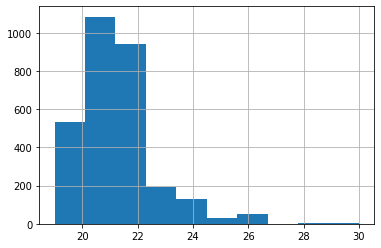

In [11]:
# Distribution of ages
dataset.Age.hist()

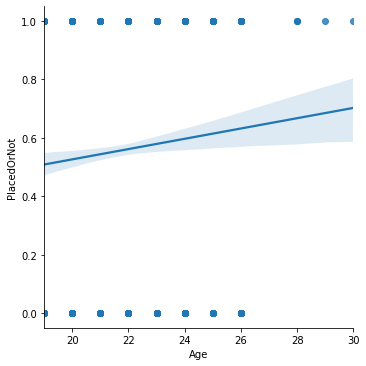

In [12]:
# Seeing if there is any notable correlation betweeen age and placement
sb.lmplot(x='Age', y='PlacedOrNot', data=dataset)

In [13]:
# Look at the amount of internships that applicants had
dataset.Internships.value_counts()

0    1331
1    1234
2     350
3      51
Name: Internships, dtype: int64

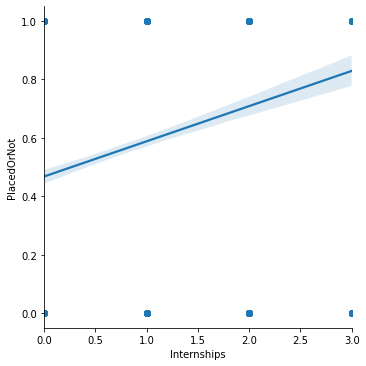

In [14]:
# Check if there is obvious correlation between number of internships and placement
sb.lmplot(x='Internships', y='PlacedOrNot', data=dataset)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


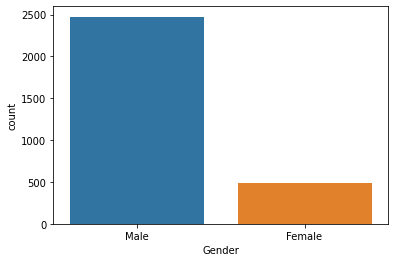

In [15]:
# What is the gender of the applicants
sb.countplot('Gender', data=dataset)

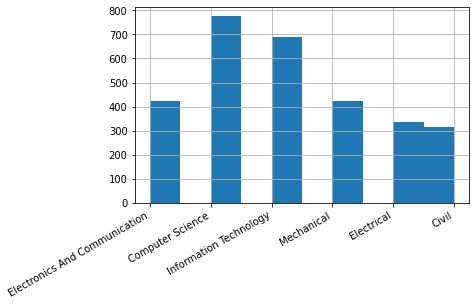

In [16]:
# what majors are applying to this program
dataset.Stream.hist().figure.autofmt_xdate()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


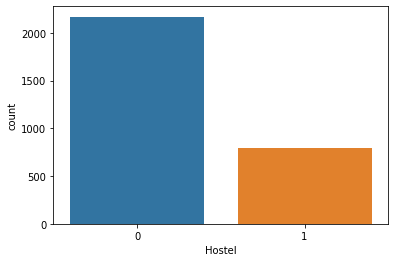

In [17]:
# Did students live in a hostel or not
dataset.Hostel.value_counts()
sb.countplot('Hostel', data=dataset)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


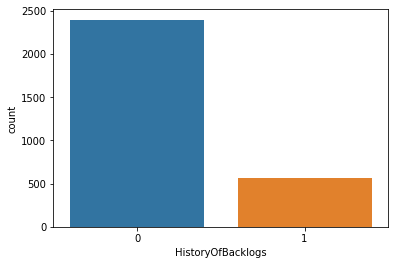

In [18]:
# See how many students have a history of backlog in any subject
dataset.HistoryOfBacklogs.value_counts()
sb.countplot('HistoryOfBacklogs', data=dataset)

One bit of preprocessing that we have to do before we can actually apply logistic regression is to remove all the strings from the dataset. They have to all be turned to integers so that the regression can understand the input. This needs to be done for both the stream and gender columns. This can easily be done with sklearn's label encoder. 

In [19]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
dataset.Stream = encoder.fit_transform(dataset.Stream)
dataset.Gender = encoder.fit_transform(dataset.Gender)
# see if the label encoding worked
dataset.head()

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,1,3,1,8,1,1,1
1,21,0,1,0,7,1,1,1
2,22,0,4,1,6,0,0,1
3,21,1,4,0,8,0,1,1
4,22,1,5,0,8,1,0,1


The next step to getting our data ready for training is to split off the 'PlacedOrNot' column, as this is the label for our dataset. It needs to be use for validation in the loss function and should not be apart of the entries.

In [20]:
X = dataset.drop('PlacedOrNot', 1)
y = dataset['PlacedOrNot']

After this we need to add another column to the dataset with all ones that will serve as the bias feature. This can be done by converting the dataframe to a numpy array and adding a ones column. This also has the added benefit of staying with numpy arrays, which is easier to do the math on when compared to a dataframe.

In [21]:
import numpy as np
X = X.to_numpy()
X = np.c_[X, np.ones(X.shape[0])]


Lastly we are going to split our data into some testing data and some training data, using another built in sklearn function.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Task 3

The first step in the actual machine learning is to implement all the things that are needed for the different varieties of gradient descent

In [23]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def cost(y, A, m):
  return -1/m * np.sum(y * np.log(A) + (1-y) * (np.log(1-A)))

def logistic_regression(w, X, y, m, n):
  A = sigmoid(np.dot(X, w.T))
  l = cost(y, A, m)
  dw = np.dot((A-y).T, X)/m
  return (A, l, dw)

def predict(w, X):
    probability = sigmoid(np.dot(X, w.T))
    values = np.where(probability >= .5, 1, 0)
    return np.squeeze(values)

The next step is to implement the two different versions of gradient descent. The first will be batch gradient descent as shown below:

In [24]:
def bgd(X, y):
  lr = .01
  num_epochs = 100
  w = np.zeros((1,X.shape[1]))
  loss=[]
  for i in range(num_epochs):
    _, l, dw = logistic_regression(w, X, y, X.shape[0], X.shape[1])
    w = w - lr*dw
    loss.append(l)
  return w, loss

# y_train = np.reshape(y_train, (y_train.shape[0], 1))
# bgdw, bgdLoss = bgd(X_train, y_train)
# print(w.shape)
# print(loss)
# print(predict(w, X_test))



The other variation on the vanialla gradient descent is mini batch gradient descent, as shown below:


In [25]:
def make_batch(X, size):
  return np.split(X, np.arange(size,len(X),size))

In [26]:
def mbgd(X, y):
  lr = .01
  num_epochs = 100
  w = np.zeros((1,X.shape[1]))
  loss = []
  for i in range(num_epochs):
    np.random.shuffle(X_train)
    for batch in make_batch(X, 50):
      _, l, dw = logistic_regression(w, X, y, X.shape[0], X.shape[1])
      w = w - lr*dw
      loss.append(l)
    return w, loss

# mbgdw, mbgdLoss = mbgd(X_train, y_train)
# print(w.shape)
# print(loss)
# print(predict(w, X_test))


# Task 4

Now we are going to use two optimizers, followed by a conclusion that states all of the results and compares them. The first that we are using is adagrad, whose implementation is shown below.

In [27]:
import math
from random import sample
def adagrad(grad_func, w, X, y,stepsize = 1e-2,fudge_factor = 1e-6,max_it=100,minibatch_ratio=0.01):
  gti=np.zeros(w.shape[0])
  ld=len(X)
  loss = []
  minibatchsize = int(math.ceil(len(X)*minibatch_ratio))
  for t in range(max_it):
      s=sample(range(ld),minibatchsize)
      sd=[X[idx] for idx in s]
      _,l,grad=grad_func(w, X, y, X.shape[0], X.shape[1])
      loss.append(l)
      grad**2
      adjusted_grad = grad / (fudge_factor + np.sqrt(gti))
      w = w - stepsize*adjusted_grad
  return w, loss

#adagrad(logistic_regression, np.zeros((1,X.shape[1])), X_train, y_train)

The next optimizer to be implemented is RMSProp as shown below:

In [28]:
def RMSProp(X, y):
  lr = .01
  num_epochs = 100
  w = np.zeros((1,X.shape[1]))
  loss=[]
  alpha = 0.01
  beta = 0.9
  v = 0
  for i in range(num_epochs):
    _, l, dw = logistic_regression(w, X, y, X.shape[0], X.shape[1])
    v = beta * v + (1 - beta) * dw
    w_prev = w
    w = w - alpha * v
    loss.append(l)
  return w, loss

Before we can actually draw our conclusions for the different algorithms and optimizers we have to time them and view their losses, as shown below:

In [29]:
import time
#looking at the run time of batch gradient descent, and the final loss value
start_time = time.time()
bgdw, bgdLoss = bgd(X_train, y_train)
end_time = time.time()
print(end_time - start_time)
print(bgdLoss[len(bgdLoss) - 1])

44.31331205368042
4.327666369641258


In [30]:
start_time = time.time()
mbgdw, mbgdLoss = mbgd(X_train, y_train)
end_time = time.time()
print(end_time - start_time)
print(mbgdLoss[len(mbgdLoss) - 1])

19.81255006790161
9.42083283872434


In [31]:
start_time = time.time()
adagw, adagLoss = adagrad(logistic_regression, np.zeros((1,X.shape[1])), X_train, y_train)
end_time = time.time()
print(end_time - start_time)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


38.379324436187744


In [32]:
start_time = time.time()
rmsw, rmsLoss = RMSProp(X_train, y_train)
end_time = time.time()
print(end_time - start_time)
print(rmsLoss[len(rmsLoss) - 1])

44.03494477272034
0.23347589349631714


# Conclusion
Based off of all of these results, it is very clear that all of the algorithms converge to roughly the same loss value with one exception. This makes sense as even though they are different algorithms they should be finding roughly the same insights in the data and tuning the parameters thusly. The one algorithm that gets a much better loss value is RMSProp. I think that Adagrad could also produce a better loss value, but my implementation struggles. So this means that optimizers result in a much better final loss value, and are thus obviously more accurate. When it comes to speed there is one clear winner though, and that is mini batch gradient descent. It makes sense that this would go quickly because it is using the smaller batches at each iteration. With all of this being said, for this specific problem given this data set mini batch gradient descent seems to be the most effective and not the optimizer algorithms. This is because the smaller loss value might not be worth the time increase with this small dataset. Even though this is the case for this problem I dont believe that it would be the general case. I think the reason the optimizers werent the most effective with this dataset is because it is a smaller dataset and is thus easier to train on. The optimizer algorithms would do a better job when the data is bigger, more complex, and has far more features. 